In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

from google.colab import drive
drive.mount('/content/drive')

class MLP(nn.Module):
  def __init__(self, n_units, init_scale=1.0):
    super(MLP, self).__init__()

    self._n_units = copy.copy(n_units)
    self._layers = []
    for i in range(1, len(n_units)):
      layer = nn.Linear(n_units[i-1], n_units[i], bias=False)
      variance = math.sqrt(2.0 / (n_units[i-1] + n_units[i]))
      layer.weight.data.normal_(0.0, init_scale * variance)
      self._layers.append(layer)

      name = 'fc%d' % i
      if i == len(n_units) - 1:
        name = 'fc'  # the prediction layer is just called fc
      self.add_module(name, layer)


  def forward(self, x):
    x = x.view(-1, self._n_units[0])
    out = self._layers[0](x)
    for layer in self._layers[1:]:
      out = F.relu(out)
      out = layer(out)
    return out


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/'My Drive'

/content/drive/My Drive


In [0]:
def get_data():
  normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
  transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize])
  transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])
  train_dataset = datasets.CIFAR10(root='data', 
                                train=True, 
                                transform=transform_train,
                                download=True)
  test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transform_test,
                                download=True)
  train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=128,
                          num_workers=4,
                          shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=128,
                         num_workers=4,
                         shuffle=False)
  return train_loader, test_loader

In [0]:
def compute_acc(model, data_loader):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
        features, targets = features.to(device), targets.to(device)
        probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [0]:
criterion = nn.CrossEntropyLoss()

epoch_max = 400

train_loader, test_loader = get_data() #fix the seed of the random labels 

torch.manual_seed(0) #iterate through 10 random inits
mlp_spec = '512x512x512'
n_units = [int(x) for x in mlp_spec.split('x')] # hidden dims
n_units.append(10)  # output dim
n_units.insert(0, 32*32*3)        # input dim
model = MLP(n_units)
optimizer = torch.optim.SGD(model.parameters(), .01, momentum=0.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50, 100, 150, 200, 250, 300, 350], gamma=0.1, last_epoch=-1)

cost_list = []
train_acc_list = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

  

for epoch in range(epoch_max):
  model.train()
  for batch_idx, (features, targets) in enumerate(train_loader):
    # compute output
    features, targets = features.to(device), targets.to(device)
    output = model(features)
    loss = criterion(output, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    cost_list.append(loss.item())
    if not batch_idx % 150:
      print (f'Epoch: {epoch+1:03d}/{epoch_max:03d} | '
                  f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                  f' Cost: {loss:.4f} |'
                  f'Seed {0:03d} |' )
  if epoch % 10 == 0:
        torch.save(model, 'MLP_3x512_truelabels_iter0_LongTraining')
  model.eval()
  with torch.set_grad_enabled(False): # save memory during inference
    train_acc = compute_acc(model, train_loader)        
    print(f'Epoch: {epoch+1:03d}/{epoch_max:03d}\n'
              f'Train ACC: {train_acc:.2f}')
    train_acc = train_acc.cpu()
    train_acc_list.append(train_acc)
    zero = torch.Tensor([0.0])
    if torch.allclose(train_acc, zero):
      torch.save(model, 'MLP_3x512_truelabels_iter0_LongTraining')
      break
  scheduler.step()

np.save('MLP_3x512_truelabels_iter0_LongTraining', cost_list)
np.save('MLP_3x512_truelabels_iter0_LongTraining', train_acc_list)

 

Files already downloaded and verified
Files already downloaded and verified
Epoch: 001/400 | Batch 000/391 | Cost: 2.5156 |Seed 000 |
Epoch: 001/400 | Batch 150/391 | Cost: 1.7065 |Seed 000 |
Epoch: 001/400 | Batch 300/391 | Cost: 1.6805 |Seed 000 |


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 001/400
Train ACC: 50.00
Epoch: 002/400 | Batch 000/391 | Cost: 1.5653 |Seed 000 |
Epoch: 002/400 | Batch 150/391 | Cost: 1.4449 |Seed 000 |
Epoch: 002/400 | Batch 300/391 | Cost: 1.3133 |Seed 000 |
Epoch: 002/400
Train ACC: 55.67
Epoch: 003/400 | Batch 000/391 | Cost: 1.2539 |Seed 000 |
Epoch: 003/400 | Batch 150/391 | Cost: 1.1665 |Seed 000 |
Epoch: 003/400 | Batch 300/391 | Cost: 1.4040 |Seed 000 |
Epoch: 003/400
Train ACC: 61.13
Epoch: 004/400 | Batch 000/391 | Cost: 1.1293 |Seed 000 |
Epoch: 004/400 | Batch 150/391 | Cost: 1.2246 |Seed 000 |
Epoch: 004/400 | Batch 300/391 | Cost: 1.0755 |Seed 000 |
Epoch: 004/400
Train ACC: 64.93
Epoch: 005/400 | Batch 000/391 | Cost: 0.9718 |Seed 000 |
Epoch: 005/400 | Batch 150/391 | Cost: 1.0389 |Seed 000 |
Epoch: 005/400 | Batch 300/391 | Cost: 1.0682 |Seed 000 |
Epoch: 005/400
Train ACC: 67.82
Epoch: 006/400 | Batch 000/391 | Cost: 0.9216 |Seed 000 |
Epoch: 006/400 | Batch 150/391 | Cost: 0.9016 |Seed 000 |
Epoch: 006/400 | Batch 300/3

KeyboardInterrupt: ignored

In [0]:
def get_data_random(train_bs=200, test_bs=1000):
  normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
  transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize])
  transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])
  train_dataset = datasets.CIFAR10(root='data', 
                                train=True, 
                                transform=transform_train,
                                download=True)
  test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transform_test,
                                download=True)
  
  train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=train_bs,
                          num_workers=4,
                          shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=test_bs,
                         num_workers=4,
                         shuffle=False)
  return train_loader, test_loader

In [0]:
import math
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt


def get_esd_plot(eigenvalues, weights, label):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7, label=label)
    plt.legend()
    #plt.plot(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvalue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.axis([-5,20, None, None])
    plt.tight_layout()
    plt.show()

def compare_esd_plot(eigenvalues, weights, random_eigen, random_weight):
    density, grids = density_generate(eigenvalues, weights)
    random_density, random_grids = density_generate(random_eigen, random_weight)
    plt.clf()
    plt.semilogy(random_grids, random_density + 1.0e-7, label='random')
    plt.semilogy(grids, density + 1.0e-7, label='true')
    plt.legend()
    #plt.plot(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.axis([-1, 1, None, None])
    plt.tight_layout()
    plt.show()
    plt.savefig('example.pdf')


def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids


def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

In [0]:
from __future__ import print_function

import json
import os
import sys

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from hessian import *

import math
import copy

# Settings

# set random seed to reproduce the work
torch.manual_seed(0)


# get dataset
train_loader, test_loader = get_data_random(train_bs=100, test_bs=1)
##############
# Get the hessian data
##############
batch_num = -1.

if batch_num == 1:
    for inputs, labels in train_loader:
        hessian_dataloader = (inputs, labels)
        break
else:
    hessian_dataloader = []
    for i, (inputs, labels) in enumerate(train_loader):
        hessian_dataloader.append((inputs, labels))
        if i == batch_num - 1:
            break

criterion = nn.CrossEntropyLoss()  # label loss

###################
# Get model checkpoint, get saving folder
###################

trace_list = []
eigen_list = []


model = model.to('cuda:0')
model.eval()
if batch_num == 1:
  hessian_comp = hessian(model,
                           criterion,
                           data=hessian_dataloader,
                           cuda=True)
else:
  hessian_comp = hessian(model,
                           criterion,
                           dataloader=hessian_dataloader,
                           cuda=True)

print(
    '********** finish data loading and begin Hessian computation **********')

top_eigenvalues, _ = hessian_comp.eigenvalues()
trace = hessian_comp.trace()
density_eigen, density_weight = hessian_comp.density(iter=100)

trace_list.append(trace)
eigen_list.append((density_eigen, density_weight))


print('\n***Top Eigenvalues: ', top_eigenvalues)
print('\n***Trace: ', np.mean(trace))


Files already downloaded and verified
Files already downloaded and verified
********** finish data loading and begin Hessian computation **********

***Top Eigenvalues:  [0.607335090637207]

***Trace:  66.23827958106995


In [0]:
np.save("MLP_3x512_truelabel_eigen", density_eigen)
np.save("MLP_3x512_truelabel_weight", density_weight)

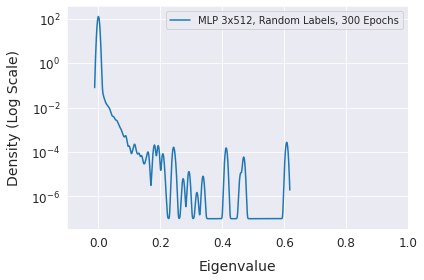

In [0]:
import seaborn as sns
sns.set_style("darkgrid")

density, grids = density_generate(density_eigen, density_weight)
plt.legend()
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvalue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.axis([-0.1,1, None, None])
plt.tight_layout()

In [0]:
random_eigen = np.load("MLP_3x512_randomlabel_eigen.npy")
random_weight = np.load("MLP_3x512_randomlabel_weight.npy")

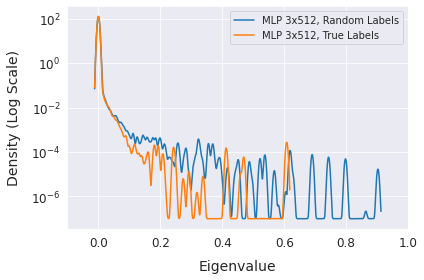

In [0]:
import seaborn as sns
sns.set_style("darkgrid")

density2, grids2 = density_generate(random_eigen, random_weight)
density, grids = density_generate(density_eigen, density_weight)
plt.semilogy(grids2, density2 + 1.0e-7, label="MLP 3x512, Random Labels")
plt.semilogy(grids, density + 1.0e-7, label="MLP 3x512, True Labels")
plt.legend()
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvalue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.axis([-0.1,1, None, None])
plt.tight_layout()